In [35]:
import unittest
import numpy as np
from collections import deque
from PIL import Image
import pandas as pd
import csv
from skimage.measure import find_contours

# 1.1 Flood Fill Algorithm

## Flood Fill Algorithm Implementation

In [2]:
# Flood Fill Algorithm adapted to collect pixel coordinates
def flood_fill_collect_coords(image, start, label, labels):
    """
    Flood fill algorithm that collects coordinates of the filled area and applies a unique label to each area.
    """
    rows, cols = image.shape
    original_value = image[start]
    if original_value != 255:  # Not a white pixel, or already visited
        return []
    
    queue = deque([start])
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    coords = []  # To store coordinates of the current particle
    
    while queue:
        r, c = queue.popleft()
        if image[r, c] == 255:  # Check if the pixel is white and not yet visited
            image[r, c] = label  # Mark this pixel with a unique label
            labels[r, c] = label  # Assign the label to the labels matrix
            coords.append((r, c))
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and image[nr, nc] == 255:
                    queue.append((nr, nc))
    return coords


## Unittests for the Flood Fill Algorithm

In [3]:
class TestFloodFillCollectCoords(unittest.TestCase):
    def setUp(self):
        # Create some image examples for testing
        self.image1 = np.array([
            [255, 255, 0, 0],
            [255, 255, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 255, 255]
        ])
        self.labels1 = np.zeros_like(self.image1)

        self.image2 = np.array([
            [0, 0, 0, 0],
            [0, 255, 255, 0],
            [0, 255, 255, 0],
            [0, 0, 0, 0]
        ])
        self.labels2 = np.zeros_like(self.image2)

        self.image3 = np.array([
            [255, 0, 0, 255],
            [0, 0, 0, 0],
            [0, 255, 0, 0],
            [0, 0, 0, 0]
        ])
        self.labels3 = np.zeros_like(self.image3)

    def test_flood_fill_image1(self):
        # Fill the top-left white region in image1
        coords = flood_fill_collect_coords(self.image1, (0, 0), label=1, labels=self.labels1)
        expected_coords = [(0, 0), (0, 1), (1, 0), (1, 1)]
        self.assertEqual(sorted(coords), sorted(expected_coords))
        self.assertTrue((self.labels1[:2, :2] == 1).all())

    def test_flood_fill_image2(self):
        # Fill the central white region in image2
        coords = flood_fill_collect_coords(self.image2, (1, 1), label=2, labels=self.labels2)
        expected_coords = [(1, 1), (1, 2), (2, 1), (2, 2)]
        self.assertEqual(sorted(coords), sorted(expected_coords))
        self.assertTrue((self.labels2[1:3, 1:3] == 2).all())

    def test_flood_fill_image3(self):
        # Fill the first white pixel in the top row of image3
        coords = flood_fill_collect_coords(self.image3, (0, 0), label=3, labels=self.labels3)
        expected_coords = [(0, 0)]
        self.assertEqual(sorted(coords), sorted(expected_coords))
        self.assertTrue((self.labels3[0, 0] == 3))

        # Fill the isolated white pixel in the bottom-left quadrant of image3
        coords = flood_fill_collect_coords(self.image3, (2, 1), label=4, labels=self.labels3)
        expected_coords = [(2, 1)]
        self.assertEqual(sorted(coords), sorted(expected_coords))
        self.assertTrue((self.labels3[2, 1] == 4))

unittest.main(argv=[''], verbosity=2, exit=False)


test_flood_fill_image1 (__main__.TestFloodFillCollectCoords) ... ok
test_flood_fill_image2 (__main__.TestFloodFillCollectCoords) ... ok
test_flood_fill_image3 (__main__.TestFloodFillCollectCoords) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.015s

OK


## Apply and visualize the floodfill algorithm

In [4]:
# Load the image file
image_path = 'shapes_binary.png'
image = Image.open(image_path)
image_np = np.array(image)

# Display the image's shape and type to understand what we are working with
image_np.shape, image_np.dtype


((1024, 1024), dtype('uint8'))

In [57]:
# Initialize variables
labeled_image = np.copy(image_np)  # Copy of the image to apply labels
labels = np.zeros_like(image_np)  # Matrix to hold label data
particle_coords = {}  # Dictionary to hold coordinates for each particle
label_counter = 1  # Start labeling particles from 1

# Process the image to find all particles
def extract_particles(labeled_image, labels, particle_coords, label_counter):
    for i in range(image_np.shape[0]):
        for j in range(image_np.shape[1]):
            if labeled_image[i, j] == 255:  # If the pixel is white and not yet visited
                coords = flood_fill_collect_coords(labeled_image, (i, j), label_counter, labels)
                if coords:
                    particle_coords[label_counter] = coords
                    label_counter += 1

# Now, let's save the results to a CSV file
    all_particles = []
    for label, coordinates in particle_coords.items():
        for coord in coordinates:
            all_particles.append([label, coord[0], coord[1]])
            
    return all_particles

all_particles = extract_particles(labeled_image, labels, particle_coords, label_counter)
df_particles = pd.DataFrame(all_particles, columns=['Particle', 'Row', 'Column'])

csv_path = 'particles.csv'
df_particles.to_csv(csv_path, index=False)

# Check how many particles we've detected
len(particle_coords)


28

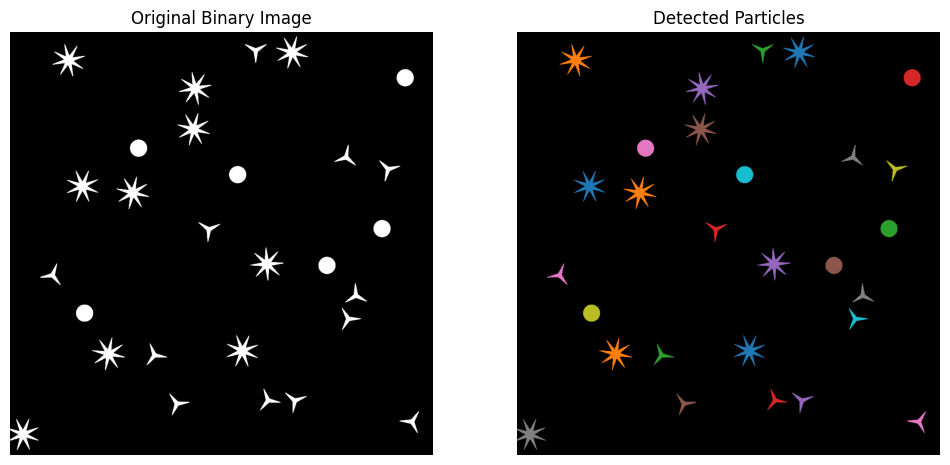

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Generate colors for each particle
colors = list(mcolors.TABLEAU_COLORS.keys())  # Use Tableau colors for differentiation
extended_colors = colors * (len(particle_coords) // len(colors) + 1)  # Repeat colors if not enough

# Create a color-mapped image
color_mapped_image = np.zeros((image_np.shape[0], image_np.shape[1], 3), dtype=np.uint8)
for label, coords in particle_coords.items():
    color = mcolors.to_rgb(extended_colors[label-1])  # Get RGB color
    for (r, c) in coords:
        color_mapped_image[r, c] = [int(255 * ch) for ch in color]  # Apply the color

# Plot the original and the color-mapped images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_np, cmap='gray')
ax[0].set_title('Original Binary Image')
ax[0].axis('off')

ax[1].imshow(color_mapped_image)
ax[1].set_title('Detected Particles')
ax[1].axis('off')

plt.show()

# 1.2 Isovalue Contours

## detect the particles using isocontours

In [31]:
def find_starting_point(image):
    """ Find the first edge pixel to start the contour tracing. """
    rows, cols = image.shape
    for i in range(rows):
        for j in range(cols):
            if image[i, j] == 1:
                # Check if it's a boundary pixel
                if i == 0 or i == rows - 1 or j == 0 or j == cols - 1 or \
                   image[i-1, j] == 0 or image[i+1, j] == 0 or \
                   image[i, j-1] == 0 or image[i, j+1] == 0:
                    return i, j
    return None

def trace_contour(image, start_i, start_j, label):
    """ Trace the contour from the starting point and mark the pixels. """
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right
    stack = [(start_i, start_j)]
    result = []
    visited = set(stack)

    while stack:
        i, j = stack.pop()
        result.append((label, j, i))  # Storing (label, x, y)
        for di, dj in directions:
            ni, nj = i + di, j + dj
            if 0 <= ni < image.shape[0] and 0 <= nj < image.shape[1]:
                if image[ni, nj] == 1 and (ni, nj) not in visited:
                    # Check if it's an edge pixel
                    if ni == 0 or ni == image.shape[0] - 1 or nj == 0 or nj == image.shape[1] - 1 or \
                       image[ni-1, nj] == 0 or image[ni+1, nj] == 0 or \
                       image[ni, nj-1] == 0 or image[ni, nj+1] == 0:
                        stack.append((ni, nj))
                        visited.add((ni, nj))
    return result

def extract_contours(image):
    """ Extract all contours from the binary image. """
    # Ensure image is boolean
    image = image > 0
    labeled_image = np.zeros_like(image, dtype=np.int32)  # Image to store labels
    label = 1
    results = []

    while True:
        start_point = find_starting_point(image - labeled_image)  # Find new contour start
        if not start_point:
            break
        contour_data = trace_contour(image, *start_point, label)
        for _, x, y in contour_data:
            labeled_image[y, x] = label
        results.extend((data[0], data[2], data[1]) for data in contour_data)
        label += 1
    print(results)
    return results

In [32]:
class TestIsocontours(unittest.TestCase):

    def setUp(self):
        # Create some image examples for testing
        self.image1 = np.array([
            [255, 255, 0, 0],
            [255, 255, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 255, 255]
        ])

        self.image2 = np.array([
            [0, 0, 0, 0, 0],
            [0, 255, 255, 255, 0],
            [0, 255, 255, 255, 0],
            [0, 255, 255, 255, 0],
            [0, 0, 0, 0, 0]
        ])

        self.image3 = np.array([
            [255, 0, 0, 255],
            [0, 0, 0, 0],
            [0, 255, 0, 0],
            [0, 0, 0, 0]
        ])

    def test_isocontour_image1(self):
        # Fill the top-left white region in image1
        coords = extract_contours(self.image1)
        expected_coords = [(1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1),(2,3,2),(2,3,3)]
        self.assertEqual(sorted(coords), sorted(expected_coords))

    def test_isocontour_image2(self):
        # Fill the central white region in image2
        coords = extract_contours(self.image2)
        expected_coords = [(1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 1), (1, 2, 3), (1, 3, 1), (1, 3, 2), (1, 3, 3)]
        self.assertEqual(sorted(coords), sorted(expected_coords))

    def test_isocontour_image3(self):
        # Fill the first white pixel in the top row of image3
        coords = extract_contours(self.image3)
        expected_coords = [(1, 0, 0),(2, 0, 3),(3, 2, 1)]
        self.assertEqual(sorted(coords), sorted(expected_coords))
        
unittest.main(argv=[''], verbosity=2, exit=False)


test_flood_fill_image1 (__main__.TestFloodFillCollectCoords) ... ok
test_flood_fill_image2 (__main__.TestFloodFillCollectCoords) ... ok
test_flood_fill_image3 (__main__.TestFloodFillCollectCoords) ... ok
test_isocontour_image1 (__main__.TestIsocontours) ... ok
test_isocontour_image2 (__main__.TestIsocontours) ... FAIL
test_isocontour_image3 (__main__.TestIsocontours) ... ok

FAIL: test_isocontour_image2 (__main__.TestIsocontours)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Marc\AppData\Local\Temp\ipykernel_109200\2166123585.py", line 37, in test_isocontour_image2
    self.assertEqual(sorted(coords), sorted(expected_coords))
AssertionError: Lists differ: [(1, [77 chars]3, 3), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2,[54 chars], 3)] != [(1, [77 chars]3, 3)]

First list contains 9 additional elements.
First extra element 8:
(2, 1, 1)

  [(1, 1, 1),
   (1, 1, 2),
   (1, 1, 3),
   (1, 2, 1),
   (1, 2, 3),
   (1, 3,

[(1, 0, 0), (1, 0, 1), (1, 1, 1), (1, 1, 0), (2, 3, 2), (2, 3, 3)]
[(1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 3), (1, 3, 3), (1, 3, 2), (1, 3, 1), (1, 2, 1), (2, 2, 2), (2, 2, 3), (2, 3, 3), (2, 1, 3), (2, 2, 1), (2, 3, 1), (2, 1, 1), (2, 3, 2), (2, 1, 2)]
[(1, 0, 0), (2, 0, 3), (3, 2, 1)]


In [18]:
# Load the image again
image_path = 'shapes_binary.png'
image = Image.open(image_path)
image_array = np.array(image)

# Applying the function to the image
contour_points = extract_contours(image_array)

# Save the results to a CSV file
output_path = 'contours.csv'
with open(output_path, 'w', newline='') as csvfile:
    contour_writer = csv.writer(csvfile)
    contour_writer.writerow(['Label','X', 'Y'])
    for point in contour_points:
        contour_writer.writerow(point)

contour_points

[(1, 693, 11),
 (1, 694, 11),
 (1, 694, 12),
 (1, 694, 13),
 (1, 694, 14),
 (1, 694, 15),
 (2, 692, 12),
 (2, 692, 13),
 (2, 692, 14),
 (3, 693, 12),
 (3, 694, 12),
 (3, 694, 13),
 (3, 694, 14),
 (3, 694, 15),
 (3, 694, 11),
 (3, 692, 12),
 (3, 692, 13),
 (3, 692, 14),
 (3, 693, 11),
 (4, 663, 14),
 (4, 664, 14),
 (4, 663, 15),
 (4, 663, 16),
 (5, 665, 15),
 (6, 691, 15),
 (6, 691, 16),
 (7, 666, 16),
 (7, 666, 17),
 (8, 693, 16),
 (8, 693, 17),
 (8, 693, 18),
 (8, 693, 19),
 (8, 693, 20),
 (8, 693, 21),
 (9, 664, 17),
 (9, 664, 18),
 (10, 690, 17),
 (10, 690, 18),
 (11, 667, 18),
 (12, 665, 19),
 (12, 665, 20),
 (12, 665, 21),
 (13, 668, 19),
 (14, 689, 19),
 (14, 689, 20),
 (14, 689, 21),
 (15, 669, 20),
 (15, 669, 21),
 (16, 666, 22),
 (16, 666, 23),
 (17, 670, 22),
 (18, 688, 22),
 (18, 688, 23),
 (19, 692, 22),
 (19, 692, 23),
 (19, 692, 24),
 (19, 692, 25),
 (19, 692, 26),
 (19, 692, 27),
 (19, 692, 28),
 (20, 671, 23),
 (20, 671, 24),
 (21, 667, 24),
 (21, 667, 25),
 (21, 667, 2

## Computing the Area of Each Particle

In [29]:
# Initialize variables
labeled_image = np.copy(image_np)  # Copy of the image to apply labels
labels = np.zeros_like(image_np)  # Matrix to hold label data
particle_coords = {}  # Dictionary to hold coordinates for each particle
label_counter = 1  # Start labeling particles from 1

# Process the image to find all particles
def calc_area(labeled_image, labels, particle_coords, label_counter):
    for i in range(image_np.shape[0]):
        for j in range(image_np.shape[1]):
            if labeled_image[i, j] == 255:  # If the pixel is white and not yet visited
                area = len(flood_fill_collect_coords(labeled_image, (i, j), label_counter, labels))
                if area>0:
                    particle_coords[label_counter] = area
                    label_counter += 1

particle_coords = calc_area(labeled_image, labels, particle_coords, label_counter)

print(particle_coords)

{1: 1569, 2: 1571, 3: 510, 4: 1345, 5: 1581, 6: 1578, 7: 1345, 8: 506, 9: 510, 10: 1349, 11: 1573, 12: 1578, 13: 1348, 14: 508, 15: 1576, 16: 1347, 17: 504, 18: 512, 19: 1344, 20: 510, 21: 1575, 22: 1581, 23: 511, 24: 499, 25: 513, 26: 508, 27: 505, 28: 1546}


### Computing the Length of the Contour

In [43]:
contours = find_contours(image_np, 254)
contours[:2]

[array([[ 87.00571429, 672.        ],
        [ 87.00408163, 671.        ],
        [ 87.        , 670.99607843],
        ...,
        [ 86.        , 672.2       ],
        [ 87.        , 672.00408163],
        [ 87.00571429, 672.        ]]),
 array([[106.00512821, 152.        ],
        [106.00444444, 151.        ],
        [106.        , 150.99607843],
        ...,
        [105.        , 152.00392157],
        [106.        , 152.00392157],
        [106.00512821, 152.        ]])]

In [44]:
from scipy.spatial.distance import euclidean

# Function to calculate the length of a contour
def contour_length(contour):
    return sum(euclidean(contour[i], contour[i+1]) for i in range(len(contour)-1))

# Calculate the length of each contour
contour_lengths = [contour_length(contour) for contour in contours]

# Display the lengths of the first few contours
contour_lengths[:10]

[507.12816018323167,
 500.8922204572328,
 175.37491069243123,
 134.34530975934513,
 498.9649998425572,
 502.90810227724694,
 134.339102920382,
 175.40266350091446,
 175.7919044803094,
 134.35939051222644]

In [48]:
from scipy.spatial import ConvexHull

# Function to compute the area of the convex hull and original contour using the shoelace formula
def area_polygon(points):
    x = points[:, 0]
    y = points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# Compute convex hull areas and porosities
convex_hull_areas = []
original_contour_areas = []
porosities = []

for contour in contours:
    hull = ConvexHull(contour)
    hull_area = area_polygon(contour[hull.vertices])
    contour_area = area_polygon(contour)
    
    convex_hull_areas.append(hull_area)
    original_contour_areas.append(contour_area)
    
    if hull_area == 0:  # Prevent division by zero
        porosity = 0
    else:
        porosity = (hull_area - contour_area) / hull_area
    porosities.append(porosity)

# results for the first few contours
metrics = list(zip(convex_hull_areas, original_contour_areas, porosities))


particle_metrics = pd.DataFrame(metrics, columns=['Convex Hull Area', 'Contour Area', 'Porosity'])

particle_metrics.sort_values('Porosity', ascending=False)

,Convex Hull Area,Contour Area,Porosity
10,4495.434539,1358.827105,0.697732
0,4484.767400,1356.353283,0.697564
20,4483.020866,1360.816270,0.696451
11,4491.276446,1365.399393,0.695989
21,4501.494539,1369.842422,0.695692
5,4466.537162,1366.563747,0.694044
1,4445.296302,1360.422805,0.693964
4,4472.948178,1371.770209,0.693319
14,4449.279426,1369.840439,0.692121
7,1193.108974,431.887897,0.638015


In [49]:
from skimage.measure import EllipseModel

# Function to fit an ellipse to a contour and retrieve its parameters
def fit_ellipse_to_contour(contour):
    ellipse = EllipseModel()
    if ellipse.estimate(contour):  # Check if the ellipse estimation is successful
        xc, yc, a, b, theta = ellipse.params
        return {
            "center_x": xc,
            "center_y": yc,
            "major_axis_length": 2*a,  # Diameter along major axis
            "minor_axis_length": 2*b,  # Diameter along minor axis
            "rotation_angle": np.degrees(theta)  # Convert radians to degrees
        }
    else:
        return "Fit failed"

# Fit ellipses to each contour and collect the results
ellipse_params = [fit_ellipse_to_contour(contour) for contour in contours]

# Show ellipse parameters for the first few fits
ellipse_params[:10]


[{'center_x': 49.07602236668414,
  'center_y': 682.4688465781483,
  'major_axis_length': 54.84815412088059,
  'minor_axis_length': 53.99892881018296,
  'rotation_angle': 25.16448834487757},
 {'center_x': 67.90179608601117,
  'center_y': 141.7993703569269,
  'major_axis_length': 54.315277065204285,
  'minor_axis_length': 54.062473969839935,
  'rotation_angle': 10.18619808570359},
 {'center_x': 44.288358297268786,
  'center_y': 594.4961313915788,
  'major_axis_length': 37.68828296872652,
  'minor_axis_length': 37.57841268585349,
  'rotation_angle': 93.62044500193666},
 {'center_x': 110.28492987747362,
  'center_y': 956.1728110121746,
  'major_axis_length': 40.68708234528085,
  'minor_axis_length': 40.56391759643699,
  'rotation_angle': 173.23967025376368},
 {'center_x': 136.12529684154435,
  'center_y': 447.9335196324886,
  'major_axis_length': 54.48940372830628,
  'minor_axis_length': 54.29450343962425,
  'rotation_angle': 11.46764467484108},
 {'center_x': 234.95138012658438,
  'center_

# Particle Classification

## Decision Tree

In [ ]:
class TreeNode():
    def print( self, depth = 0 ):
        raise NotImplementedError()            
    def predict( self, x ):
        raise NotImplementedError()
        
class LeafNode( TreeNode ):
    def __init__( self, output_class, confidence ):
        self.output_class = output_class
        self.confidence = confidence

    def print( self, depth = 0 ):
        print( "  " * depth, "Leaf Node", self.output_class, self.confidence )
    
    def predict( self, x ):
        return self.output_class, self.confidence

class InnerNode( TreeNode ):
    def __init__( self, feature, split_value, left_child, right_child ):
        self.feature = feature
        self.split_value = split_value
        self.left_child = left_child
        self.right_child = right_child

    def print( self, depth = 0 ):
        print( "  " * depth, "Inner Node (", feature_names[self.feature], "<", self.split_value, ")" )
        self.left_child.print( depth + 1 )
        self.right_child.print( depth + 1 )
    
    def predict( self, x ):
        if x[ self.feature ] <= self.split_value:
            return self.left_child.predict( x )
        return self.right_child.predict( x )

In [ ]:
from pyexpat import features
from re import split
import numpy

def count_occurance_of_class(data_points, searched_class): #gibt die Anzahl der Vorkommen einer Klasse in einem Datensatz zurück
    count = 0
    for _, class_label in data_points:
        if class_label == searched_class:
            count += 1
    return count

def get_unqiue_classes(data_points): #gibt eine Liste mit den einzigartigen Klassen zurück
    classes = set()
    for _, class_label in data_points:
        classes.add(class_label)
    return list(classes)

def gini_index( data_points ): #berechnet den Gini-Index
    total_count = len(data_points)
    gini = 1 - sum( [ ( count_occurance_of_class(data_points, c) / total_count )**2 for c in get_unqiue_classes(data_points) ] )
    return gini
    

def split_data(data_points, feature_ind, split_value): #teilt die Daten in zwei Teile auf, basierend auf einem Grenzwert(split-value) eines Features
    left = []
    right = []
    for x, _ in data_points:
        if x[feature_ind] <= split_value:
            left.append((x, _))
        else:
            right.append((x, _))
    return left, right

def suggest_split_values( data_points, feature ): #gibt den Median und den Mittelwert der Werte eines Features zurück
    values_of_feature = []
    for x,_ in data_points:
        values_of_feature.append( x[feature] )

    return (numpy.median(values_of_feature), numpy.mean(values_of_feature))


#wählt den besten Split aus, basierend auf dem Gini-Index. 
#Es wird der Split mit dem niedrigsten Gini-Index gewählt (also der Split, der die Klassen am besten trennt)
def select_best_split(data_points):
    splits = []
    features = range(len(data_points[0][0]))
    for feature in features:
        split_values = suggest_split_values(data_points, feature)
        for value in split_values:
            left_data, right_data = split_data(data_points, feature, value)
            if len(left_data) == 0 or len(right_data) == 0:
                continue
            left_gini = gini_index(left_data)
            right_gini = gini_index(right_data)
            total_gini = left_gini + right_gini
            splits.append((feature, value, total_gini))
    splits = sorted(splits, key=lambda x: x[2])
    try:
        feature, split_value, _ = splits[0]
    except:
        print("Error: No split found")
    return (feature, split_value)

# Function to check if all points (ignoring labels) have the same value
def all_points_same_ignore_labels(data):
    """
    Returns:
    bool: True if all points are the same, False otherwise.
    """
    points = [tuple(point) for point, _ in data]
    # Return True if the set of points has length 1 or 0, implying all elements are identical or the list is empty
    return len(set(points)) <= 1

def can_stop_recursion(data_points): #überprüft, ob die Rekursion gestoppt werden kann, weil die Datenpunkte homogen sind oder die Anzahl der Datenpunkte zu gering ist
    if len(get_unqiue_classes(data_points)) == 1: #nur eine Klasse vorhanden
        return True
    elif len(data_points) <= 5: #nur 5 oder weniger Datenpunkte vorhanden
        return True
    elif all_points_same_ignore_labels(data_points): #Features sind identisch
        return True
    else: 
        return False

def decision_for_subset(data_points): #gibt die Klasse zurück, die am häufigsten vorkommt und die Konfidenz
    class_labels = get_unqiue_classes(data_points)
    count = [count_occurance_of_class(data_points, c) for c in class_labels]
    max_count = max(count)
    index = count.index(max_count)
    return class_labels[index], max_count / len(data_points)


def build_tree(data_subset):  #rekursive Funktion, die den Baum aufbaut
    if can_stop_recursion(data_subset):
        y, confidence = decision_for_subset(data_subset)
        return LeafNode(y, confidence)
    feature, splitting_value = select_best_split(data_subset)
    left_data, right_data = split_data(data_subset, feature, splitting_value)
    left_child = build_tree(left_data)
    right_child = build_tree(right_data)
    return InnerNode(feature, splitting_value, left_child, right_child)


In [ ]:
class FileFormatException(Exception):
    def __init__(self, line_number):
        super().__init__()
        self.line_number = line_number
        
def load_csv_in_sklearn_format( input_file_name, output_feature ):
    with open(input_file_name, 'r') as file:
        reader = csv.reader(file, delimiter=";")
        X = []
        Y = []
        for line_number,row in enumerate(reader):
            if line_number==0:
                n_features = len( row )
                input_features = []
                for i in range(n_features):
                    if i != output_feature:
                        input_features.append(i)               
            if len(row) != n_features:
                raise FileFormatException(line_number)
            try:
                features = []
                for i in input_features:
                    features.append(float(row[i]))
                X.append( features )
                Y.append( row[output_feature] )
            except Exception: 
                raise FileFormatException(line_number)
    return X, Y

In [55]:
# read all files from subfolder training_data
import os

def get_trainingsdata():
    folder_path = "training_data"
    file_list_csv = []
    file_list_png = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                file_list_csv.append(file_path)
            elif file.endswith(".png"):
                file_path = os.path.join(root, file)
                file_list_png.append(file_path)

    return file_list_csv.sort(), file_list_png.sort()

file_list_csv, file_list_png = get_trainingsdata()

<class 'list'>


In [ ]:

for dataset in []
    X, Y = load_csv_in_sklearn_format("iris_data.csv", output_feature=4)
    feature_names = ["Kelchblattlänge", "Kelchblattdicke", "Blütenblattlänge", "Blütenblattdicke"]
    data_points = list ( zip( X, Y ) )

    tree = build_tree( data_points)
    tree.print()

In [ ]:
extract_particles(labeled_image, labels, particle_coords, label_counter)
